**Autor:** Allyson de Lima Medeiros   
**Data:** 18-12-2018

## Menu

[Carga nos dados](#carga)

[Limpeza nos dados](#limpeza)

[Vizualização](#viz)

[Modelos](#model)

<a id='carga'></a>

# Regras de negócio

O objetivo do teste é entender como você pensa e como será sua execução no dia.  


Prova Realizada em : estado onde a pessoa realizou a prova     
Dia da Prova Realizada : data da prova   
Nota : nota de 0 a 10 da prova   
Nota da Redação : nota de 0 a 2,5   
Horário da Prova : período de realização da prova   
Estado civil : estado civil do aluno   
Escolaridade : escolaridade máxima do aluno   
Cidade de nascimento : cidade de nascimento do aluno   
Bairro onde reside : bairro de residência do aluno   

A para um aluno ser aprovado na disciplina ele deve tirar, no mínimo, 5 na nota da prova. A nota da redação como nota de desempate (entre dois alunos que tiveram nota 5 na prova, o aluno que tiver maior nota na redação tem desempenho melhor). Caso o aluno tire 0 na redação ele é reprovado automaticamente. Os alunos são divididos por estado.   

A partir destes dados, responda as seguintes perguntas:   
1) O time de marketing precisa saber qual é o público-alvo ideal para essa instituição de ensino. Quais as caraterísticas principais desse público? (DICA: O público ideal é o público de perfil ‘vencedor’ nas provas)   
2) O time de monitoria de educação precisa tomar ações preventivas para evitar que alunos reprovem na matéria. Como você pode indicar quais são os alunos que necessitam de mais ajuda? (DICA: Existem alguma forma de prever o desempenho desses alunos?)   
3) Seja criativo! Qual outro insight ou informação você consegue extrair desses dados? Descreva uma forma que alguém poderia utilizar essa informação. (DICA: Lembre que toda análise deve trazer uma informação que pode ser transformada em ação ou servir de tomada de decisão.)


# Carga nos dados

Foi criado um banco de dados na nuvem Amazon Relational Database Service(RDS) com o PostgresSQL 10.    

Esse banco conta com a infraestrutura da Amazon de disponibilidade e tolerância a falhas propiciando um ambiente seguro para futuras extrações.

Pode-se pular diretamente para a análise exploratória com o menu acima.    

A inserção poderá ser um pouco lenta pois foi utilizado um cluster gratuito do RDS.

In [1]:
# Instalando dependências

!pip install psycopg2
!pip install pandas
!pip install sklearn
!pip install mlxtend
!pip install fuzzywuzzy

In [2]:
#Importando dependências

import psycopg2
import csv

/home/deep/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
# Dados de conexão com o bd da AWS
host = "host=bdrinstance.cba0aotts6j4.us-east-2.rds.amazonaws.com"
dbname = "dbname=bdrdb"
user = "user=bdradmin"
passw = "password=12345678"
str_conn = host + ' ' + dbname + ' ' + user + ' ' + passw

In [4]:
# Drop da tabela caso queira recriá-la

#conn = psycopg2.connect(str_conn)
#cur = conn.cursor()
#cur.execute("DROP TABLE fato_ead_desempenho")
#conn.commit()


In [5]:
# Criação da tabela fato na nuvem AWS - RDS com PostgreSQL
# O banco de dados está com segurança pública para acesso
# Os dados serão inputados como text para posterior tratamento com o dataframe

#conn = psycopg2.connect(str_conn)
#cur = conn.cursor()
#cur.execute(
#    """
#    CREATE TABLE fato_ead_desempenho (
#        id text PRIMARY KEY,
#        prova_realizada_em text,
#        dia_da_prova_realizada text,
#        nota text,
#        nota_redacao text,
#        horario_da_prova text,
#        sexo text,
#        estado_civil text,
#        escolaridade text,
#        cidade_de_nascimento text,
#        bairro text
#    )
#    """
#)
#conn.commit()


In [6]:
# Inserção dos dados do CSV para o banco de dados na nuvem

#conn = psycopg2.connect(str_conn)
#cur = conn.cursor()
#with open('data/DOT_teste_data_science.csv', 'r', encoding = "ISO-8859-1") as f:
#    reader = csv.reader(f)
#    next(reader)  # Skip the header row.
#    for row in reader:
#        cur.execute(
#            "INSERT INTO fato_ead_desempenho VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)",
#            row
#        )         
#conn.commit()


Será criado uma tabela dimensão com os municípios do Brasil retirado do site do IBGE para tratamento das cidades e coleta dos estados

In [7]:
# Drop da tabela dim_municipio

#conn = psycopg2.connect(str_conn)
#cur = conn.cursor()
#cur.execute("DROP TABLE dim_municipio")
#conn.commit()

In [8]:
#conn = psycopg2.connect(str_conn)
#cur = conn.cursor()
#cur.execute(
#    """
#    CREATE TABLE dim_municipio (
#        uf text,
#        municipio text
#      
#    )
#    """
#)
#conn.commit()

In [9]:
# Inserção dos dados do CSV para o banco de dados na nuvem

#conn = psycopg2.connect(str_conn)
#cur = conn.cursor()
#with open('data/municipios.csv', 'r', encoding = "ISO-8859-1") as f:
#    reader = csv.reader(f)
#    next(reader)  
#    for row in reader:
#        cur.execute(
#            "INSERT INTO dim_municipio VALUES (%s, %s)",
#            row
#        )         
#conn.commit()

#  
#  

# Análise exploratória dos dados e pré-processamento

Ao fim da seção será disponibilizado um ambiente em memória com os dados limpos e categorizados para posterior análise estatística e modelagem de dados.

<a id='limpeza'></a>

## Limpeza e ajuste nos dados

In [11]:
# importando dependências

import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd
import unicodedata
import sklearn as sl
import matplotlib.pyplot as plt
import numpy as np
import psycopg2
from sklearn import preprocessing
from fuzzywuzzy import process

%matplotlib inline

In [12]:
# Dados de autenticação

host = "host=bdrinstance.cba0aotts6j4.us-east-2.rds.amazonaws.com"
dbname = "dbname=bdrdb"
user = "user=bdradmin"
passw = "password=12345678"
str_conn = host + ' ' + dbname + ' ' + user + ' ' + passw

In [13]:
# Realiza conexão e copia os dados para um Dataframe do pandas

conn = psycopg2.connect(str_conn)
cur = conn.cursor()
cur.execute("SELECT * FROM fato_ead_desempenho") 
columns=['id', 'prova_realizada_em', 'dia_da_prova_realizada', 'nota', 
         'nota_redacao', 'horario_da_prova', 'sexo', 'estado_civil', 
         'escolaridade', 'cidade_de_nascimento', 'bairro']
df = pd.DataFrame(cur.fetchall(), columns=columns)



conn = psycopg2.connect(str_conn)
cur = conn.cursor()
cur.execute("SELECT * FROM dim_municipio") 
columns=['uf', 'municipio']
df_cidades = pd.DataFrame(cur.fetchall(), columns=columns)

In [14]:
# Verificação dos dados iniciais e finais

df.head(5)

,id,prova_realizada_em,dia_da_prova_realizada,nota,nota_redacao,horario_da_prova,sexo,estado_civil,escolaridade,cidade_de_nascimento,bairro
0,0,GO - Goiás,13/01/2017,"7,45","2,2",manhã,Masculino,Casado(a),Ensino médio,fortaleza,Asa Sul
1,1,GO - Goiás,10/01/2017,"7,4","2,4",manhã,Masculino,Casado(a),Especialização,Recife,Norte (Águas Claras)
2,2,GO - Goiás,07/01/2017,"7,3","1,8",manhã,Masculino,Casado(a),Superior,BRASILIA,Setor Sudoeste
3,3,GO - Goiás,02/01/2017,"7,2","1,7",Noite,Masculino,Solteiro(a),Ensino médio,Brasília,Setor Norte
4,4,GO - Goiás,09/01/2017,"6,95","1,7",manhã,Feminino,Solteiro(a),Superior,BRASÍLIA,Guará I


In [15]:
df.tail()

,id,prova_realizada_em,dia_da_prova_realizada,nota,nota_redacao,horario_da_prova,sexo,estado_civil,escolaridade,cidade_de_nascimento,bairro
12095,12095,RJ - Rio de Janeiro,12/08/2016,"3,25",0,Noite,Masculino,Solteiro(a),Ensino médio,Campos dos Goytacazes,Tócos
12096,12096,RJ - Rio de Janeiro,13/08/2016,"2,75",0,manhã,Feminino,Separado(a),Nível técnico,CAMPOS DOS GOYTACAZES,Parque Imperial
12097,12097,RJ - Rio de Janeiro,08/01/2017,"2,75",0,manhã,Feminino,Casado(a),Ensino médio,CAMPOS DOS GOYTACAZES,Parque Tarcisio Miranda
12098,12098,RJ - Rio de Janeiro,11/08/2016,"2,75",0,manhã,Feminino,Casado(a),Ensino médio,Campos dos Goytacazes,Parque Jóquei Club
12099,12099,RJ - Rio de Janeiro,12/08/2016,"2,25",0,manhã,Masculino,Casado(a),Ensino médio,Campos dos goitacazes,Centro


In [16]:
# Visualizando as dimensões

df.shape

(12100, 11)

In [17]:
# Verificando dados nulos ou #N/A

missing_values_count = df.isnull().sum()
missing_values_count[0:11]

id                        0
prova_realizada_em        0
dia_da_prova_realizada    0
nota                      0
nota_redacao              0
horario_da_prova          0
sexo                      0
estado_civil              0
escolaridade              0
cidade_de_nascimento      0
bairro                    0
dtype: int64

In [18]:
(df.bairro == '#N/A').sum()

40

In [19]:
(df.loc[df['bairro'] == '#N/A']).head(5)

,id,prova_realizada_em,dia_da_prova_realizada,nota,nota_redacao,horario_da_prova,sexo,estado_civil,escolaridade,cidade_de_nascimento,bairro
352,352,PA - Pará,#N/A,"6,55","2,3",#N/A,#N/A,#N/A,#N/A,#N/A,#N/A
370,370,PA - Pará,#N/A,"6,2","1,7",#N/A,#N/A,#N/A,#N/A,#N/A,#N/A
377,377,PA - Pará,#N/A,6,"1,5",#N/A,#N/A,#N/A,#N/A,#N/A,#N/A
393,393,PA - Pará,#N/A,"5,65","1,9",#N/A,#N/A,#N/A,#N/A,#N/A,#N/A
725,725,GO - Goiás,#N/A,"6,75",2,#N/A,#N/A,#N/A,#N/A,#N/A,#N/A


In [20]:
# Removendo NA - Pois não acrescentam valor aos dados

df = df.loc[df['bairro'] != '#N/A']
len(df)

12060

In [21]:
# Ajuste das do formato das notas

df['nota'] = [x.replace(',', '.') for x in df['nota']]
df['nota_redacao'] = [x.replace(',', '.') for x in df['nota_redacao']]


# Modificanto os tipos das colunas

df['id'] = df['id'].astype(int)
df['dia_da_prova_realizada'] = pd.to_datetime(df['dia_da_prova_realizada'])
df['nota'] = df['nota'].astype(float)
df['nota_redacao'] = df['nota_redacao'].astype(float)
df.dtypes

id                                 int64
prova_realizada_em                object
dia_da_prova_realizada    datetime64[ns]
nota                             float64
nota_redacao                     float64
horario_da_prova                  object
sexo                              object
estado_civil                      object
escolaridade                      object
cidade_de_nascimento              object
bairro                            object
dtype: object

In [22]:
# Ajuste da coluna 'prova_realizada_em' com a separação em outras duas colunas

# Remoção das colunas id e prova_realizada_em, que não acrescentam valor 
# ao dataframe

new = df["prova_realizada_em"].str.split("-", n = 1, expand = True)
df["estado_realizado_em"]= new[0] 
df["cidade_realizado_em"]= new[1]
df = df.drop(['id'], axis=1)
df = df.drop(['prova_realizada_em'], axis=1)

In [23]:
df.head(5)

,dia_da_prova_realizada,nota,nota_redacao,horario_da_prova,sexo,estado_civil,escolaridade,cidade_de_nascimento,bairro,estado_realizado_em,cidade_realizado_em
0,2017-01-13,7.45,2.2,manhã,Masculino,Casado(a),Ensino médio,fortaleza,Asa Sul,GO,Goiás
1,2017-10-01,7.40,2.4,manhã,Masculino,Casado(a),Especialização,Recife,Norte (Águas Claras),GO,Goiás
2,2017-07-01,7.30,1.8,manhã,Masculino,Casado(a),Superior,BRASILIA,Setor Sudoeste,GO,Goiás
3,2017-02-01,7.20,1.7,Noite,Masculino,Solteiro(a),Ensino médio,Brasília,Setor Norte,GO,Goiás
4,2017-09-01,6.95,1.7,manhã,Feminino,Solteiro(a),Superior,BRASÍLIA,Guará I,GO,Goiás


In [24]:
# Limpeza de todos os campos, retirando acentuação, espaços, etc.

def clean_data(a):
    a = unicodedata.normalize('NFKD', a).encode('ascii', 'ignore'
            ).decode('utf-8')
    a = a.replace('(a)', '')
    a = a.upper()
    a = a.strip()
    return a

In [25]:
df['horario_da_prova'] = df['horario_da_prova'].apply(lambda x: \
        clean_data(x))
df['sexo'] = df['sexo'].apply(lambda x: \
        clean_data(x))
df['estado_civil'] = df['estado_civil'].apply(lambda x: \
        clean_data(x))
df['escolaridade'] = df['escolaridade'].apply(lambda x: \
        clean_data(x))
df['cidade_de_nascimento'] = df['cidade_de_nascimento'].apply(lambda x: \
        clean_data(x))
df['bairro'] = df['bairro'].apply(lambda x: \
        clean_data(x))
df['estado_realizado_em'] = df['estado_realizado_em'].apply(lambda x: \
        clean_data(x))
df['cidade_realizado_em'] = df['cidade_realizado_em'].apply(lambda x: \
        clean_data(x))

In [26]:
# Nova coluna com aprovação ou não do aluno de acordo com a regra de negócio

conditions = (df['nota'] >= 5) & (df['nota_redacao'] > 0)
df['APROVADO'] = np.where(conditions, 'SIM', 'NAO')

In [27]:
df.head(5)

,dia_da_prova_realizada,nota,nota_redacao,horario_da_prova,sexo,estado_civil,escolaridade,cidade_de_nascimento,bairro,estado_realizado_em,cidade_realizado_em,APROVADO
0,2017-01-13,7.45,2.2,MANHA,MASCULINO,CASADO,ENSINO MEDIO,FORTALEZA,ASA SUL,GO,GOIAS,SIM
1,2017-10-01,7.40,2.4,MANHA,MASCULINO,CASADO,ESPECIALIZACAO,RECIFE,NORTE (AGUAS CLARAS),GO,GOIAS,SIM
2,2017-07-01,7.30,1.8,MANHA,MASCULINO,CASADO,SUPERIOR,BRASILIA,SETOR SUDOESTE,GO,GOIAS,SIM
3,2017-02-01,7.20,1.7,NOITE,MASCULINO,SOLTEIRO,ENSINO MEDIO,BRASILIA,SETOR NORTE,GO,GOIAS,SIM
4,2017-09-01,6.95,1.7,MANHA,FEMININO,SOLTEIRO,SUPERIOR,BRASILIA,GUARA I,GO,GOIAS,SIM


In [28]:
# Número de pessoas que zeraram a redação e passaram na prova

len(df.loc[ (df['nota'] >= 5) & (df['nota_redacao'] == 0) ])

42

In [29]:
# Número estados realizados a prova

df['estado_realizado_em'].unique()

array(['GO', 'MG', 'MS', 'PA', 'PB', 'RJ', 'SC', 'SE', 'CE', 'PI', 'RN',
       'BA', 'RS', 'RO', 'MT', 'PE', 'RR', 'MA', 'ES', 'TO', 'AM'],
      dtype=object)

In [30]:
# Número municipios realizados a prova

df['cidade_realizado_em'].unique()

array(['GOIAS', 'MINAS GERAIS', 'MATO GROSSO DO SUL', 'PARA', 'PARAIBA',
       'RIO DE JANEIRO', 'SANTA CATARINA', 'SERGIPE', 'CEARA', 'PIAUI',
       'RIO GRANDE DO NORTE', 'BAHIA', 'RIO GRANDE DO SUL', 'RONDONIA',
       'MATO GROSSO', 'PERNAMBUCO', 'RORAIMA', 'MARANHAO',
       'ESPIRITO SANTO', 'TOCANTINS', 'AMAZONAS'], dtype=object)

Iremos adicionar um tratamento na cidade do nascimento e adição do estado do nascimento de acordo com a base de municípios do IBGE de 2017

In [31]:
df_cidades['municipio'] = df_cidades['municipio'].apply(lambda x: \
        clean_data(x))

municipios_ibge = df_cidades['municipio'].unique()

In [32]:
def get_cidade_score(cidade, municipios_ibge):
    if cidade in municipios_ibge:
        return cidade, 100

    new_name, score = process.extractOne(cidade, municipios_ibge)

    if score < 90:
        return cidade, score
    else:
        return new_name, score

def get_estado(cidade, df_cidades):
    return df_cidades.loc[df_cidades['municipio'] == cidade, 'uf'].values[0]

In [33]:
df['cidade_nascimento'],df['score']  = zip(*df['cidade_de_nascimento'].apply(lambda x: \
        get_cidade_score(x, municipios_ibge)))

In [35]:
# Removendo as cidades que não combinam em até 90 % com a tabela do ibge

df = df.loc[df['score'] >= 90]

# Removendo colunas desnecessárias

df = df.drop('score', 1)
df = df.drop('cidade_de_nascimento', 1)

In [37]:
df['estado_nascimento'] = df['cidade_nascimento'].apply(lambda x: get_estado(x, df_cidades))

In [45]:
df.loc[df['cidade_nascimento'] == 'BRASILAIA', 'cidade_nascimento'] = 'BRASILIA'
df.loc[df['cidade_nascimento'] == 'BRASILIA', 'estado_nascimento'] = 'DF'
df.loc[df['estado_civil'] == '0', 'estado_civil'] = 'NAO IDENTIFICADO'

df = df[[
    'dia_da_prova_realizada',
     'nota',
     'nota_redacao',
     'horario_da_prova',
     'sexo',
     'estado_civil',
     'escolaridade',     
     'estado_realizado_em',
     'cidade_realizado_em', 
     'bairro',
     'cidade_nascimento',
     'estado_nascimento',     
     'APROVADO'
    ]]

Salvando base tratada na nuvem

In [47]:
# Criação da tabela fato na nuvem AWS - RDS com PostgreSQL
# O banco de dados está com segurança pública para acesso
# Os dados serão inputados como text para posterior tratamento com o dataframe

conn = psycopg2.connect(str_conn)
cur = conn.cursor()
cur.execute(
    """
    CREATE TABLE base_tratada (
        dia_da_prova_realizada text,
        nota text,
        nota_redacao text,
        horario_da_prova text,
        sexo text,
        estado_civil text,
        escolaridade text,
        estado_realizado_em text,
        cidade_realizado_em text,
        bairro text,
        cidade_nascimento text,
        estado_nascimento text,
        APROVADO text
    )
    """
)
conn.commit()

In [49]:
df.to_csv('data/base_tratada.csv', index=False)

In [51]:
# Inserção dos dados do CSV para o banco de dados na nuvem

conn = psycopg2.connect(str_conn)
cur = conn.cursor()
with open('data/base_tratada.csv', 'r', encoding = "ISO-8859-1") as f:
    reader = csv.reader(f)
    next(reader)  
    for row in reader:
        cur.execute(
            "INSERT INTO base_tratada VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)",
            row
        )         
conn.commit()

<a id='viz'></a>
## Visualização dos dados

In [53]:
# Recuperando a base tratada na nuvem

conn = psycopg2.connect(str_conn)
cur = conn.cursor()
cur.execute("SELECT * FROM base_tratada") 
columns=['dia_da_prova_realizada',
         'nota',
         'nota_redacao',
         'horario_da_prova',
         'sexo',
         'estado_civil',
         'escolaridade',     
         'estado_realizado_em',
         'cidade_realizado_em', 
         'bairro',
         'cidade_nascimento',
         'estado_nascimento',     
         'APROVADO']
df = pd.DataFrame(cur.fetchall(), columns=columns)


df['dia_da_prova_realizada'] = pd.to_datetime(df['dia_da_prova_realizada'])
df['nota'] = df['nota'].astype(float)
df['nota_redacao'] = df['nota_redacao'].astype(float)


# Transformação colunas em labels para facilitar a categorização 
# e aprendizado de modelos

le_horario_da_prova = preprocessing.LabelEncoder()
le_sexo = preprocessing.LabelEncoder()
le_estado_civil = preprocessing.LabelEncoder()
le_escolaridade = preprocessing.LabelEncoder()
le_estado_realizado_em = preprocessing.LabelEncoder()
le_estado_nascimento = preprocessing.LabelEncoder()

df['horario_da_prova'] = \
    le_horario_da_prova.fit_transform(df['horario_da_prova'])
df['sexo'] = \
    le_sexo.fit_transform(df['sexo'])
df['estado_civil'] = \
    le_estado_civil.fit_transform(df['estado_civil'])
df['escolaridade'] = \
    le_escolaridade.fit_transform(df['escolaridade'])
df['estado_realizado_em'] = \
    le_estado_realizado_em.fit_transform(df['estado_realizado_em'])
df['estado_nascimento'] = \
    le_estado_nascimento.fit_transform(df['estado_nascimento'])

# criando categoria aprovado(1) ou reprovado(0)

df['APROVADO'] = np.where(df['APROVADO'] == 'SIM', 1, 0)


df.head(5)


,dia_da_prova_realizada,nota,nota_redacao,horario_da_prova,sexo,estado_civil,escolaridade,estado_realizado_em,cidade_realizado_em,bairro,cidade_nascimento,estado_nascimento,APROVADO
0,2017-01-13,7.45,2.2,0,1,0,2,4,GOIAS,ASA SUL,FORTALEZA,5,1
1,2017-10-01,7.40,2.4,0,1,0,3,4,GOIAS,NORTE (AGUAS CLARAS),RECIFE,15,1
2,2017-07-01,7.30,1.8,0,1,0,8,4,GOIAS,SETOR SUDOESTE,BRASILIA,6,1
3,2017-02-01,7.20,1.7,1,1,4,2,4,GOIAS,SETOR NORTE,BRASILIA,6,1
4,2017-09-01,6.95,1.7,0,0,4,8,4,GOIAS,GUARA I,BRASILIA,6,1


In [54]:
# Dicionário de binarização
list(le_horario_da_prova.classes_)

['MANHA', 'NOITE']

In [55]:
list(le_sexo.classes_)

['FEMININO', 'MASCULINO']

In [56]:
list(le_estado_civil.classes_)

['CASADO', 'DIVORCIADO', 'NAO IDENTIFICADO', 'SEPARADO', 'SOLTEIRO', 'VIUVO']

In [57]:
# Foi encontrado 3 casos com estado civil igual a zero, iremos retirar 
# para melhor padronização dos dados
df = df.loc[df['estado_civil'] != 0]
len(df)

7739

In [58]:
list(le_escolaridade.classes_)

['DOUTORADO',
 'ENSINO FUNDAMENTAL',
 'ENSINO MEDIO',
 'ESPECIALIZACAO',
 'MBA',
 'MESTRADO',
 'NAO INFORMADO',
 'NIVEL TECNICO',
 'SUPERIOR',
 'SUPERIOR INCOMPLETO']

In [59]:
# necessário maior limpeza dos dados com os dados de municipio
list(le_estado_nascimento.classes_)

['AC',
 'AL',
 'AM',
 'AP',
 'BA',
 'CE',
 'DF',
 'ES',
 'GO',
 'MA',
 'MG',
 'MS',
 'MT',
 'PA',
 'PB',
 'PE',
 'PI',
 'PR',
 'RJ',
 'RN',
 'RO',
 'RR',
 'RS',
 'SC',
 'SE',
 'SP',
 'TO']

In [60]:
list(le_estado_realizado_em.classes_)

['AM',
 'BA',
 'CE',
 'ES',
 'GO',
 'MA',
 'MG',
 'MS',
 'MT',
 'PA',
 'PB',
 'PE',
 'PI',
 'RJ',
 'RN',
 'RO',
 'RR',
 'RS',
 'SC',
 'SE',
 'TO']

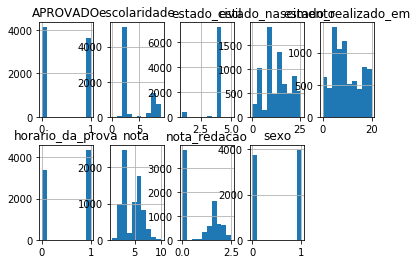

In [61]:
# Histograma Univariado
df.hist(layout = (2,5))
plt.show()

In [62]:
# Percebemos que o maior número de escolaridade é do ensino médio
df.groupby('escolaridade').size()

# Estado civil solteiro, sexo masculino e horário da prova pela manhã, melhor 
# representam o dataset

# Uma grande quantidade de pessoas zeraram a nota de redação

escolaridade
0       5
1      28
2    5119
3     174
4      12
5      38
6       4
7     245
8    1374
9     740
dtype: int64

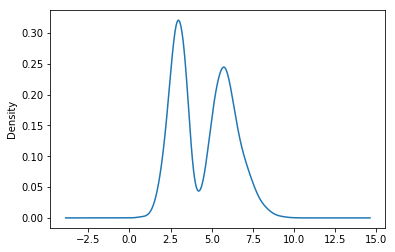

In [63]:
# Verificando a distribuição dos dados da nota objetiva verificando dois picos 
# mais constantes próximo a nota 3 e 6
df.nota.plot(kind = 'density')

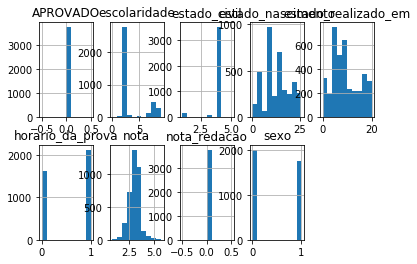

In [64]:
# Verificando o perfil das pessoas que tiraram nota de redação igual a zero, é 
# bem próxima ao perfil do 
# conjunto anterior sem filtros
(df.loc[df['nota_redacao'] == 0]).hist(layout = (2,5))
plt.show()

In [65]:
# Matriz de correlação

df.corr()

,nota,nota_redacao,horario_da_prova,sexo,estado_civil,escolaridade,estado_realizado_em,estado_nascimento,APROVADO
nota,1.000000,0.918747,-0.004952,0.120185,-0.055558,0.197459,0.028927,0.022304,0.888233
nota_redacao,0.918747,1.000000,-0.000251,0.083271,-0.029570,0.189571,0.055684,0.038204,0.909978
horario_da_prova,-0.004952,-0.000251,1.000000,0.006802,0.011590,-0.003269,0.008190,0.003926,-0.008750
sexo,0.120185,0.083271,0.006802,1.000000,0.030617,-0.019166,0.003696,-0.000710,0.087909
estado_civil,-0.055558,-0.029570,0.011590,0.030617,1.000000,-0.044632,0.004535,-0.023091,-0.049215
escolaridade,0.197459,0.189571,-0.003269,-0.019166,-0.044632,1.000000,-0.034500,-0.013818,0.171118
estado_realizado_em,0.028927,0.055684,0.008190,0.003696,0.004535,-0.034500,1.000000,0.623823,0.023446
estado_nascimento,0.022304,0.038204,0.003926,-0.000710,-0.023091,-0.013818,0.623823,1.000000,0.020943
APROVADO,0.888233,0.909978,-0.008750,0.087909,-0.049215,0.171118,0.023446,0.020943,1.000000


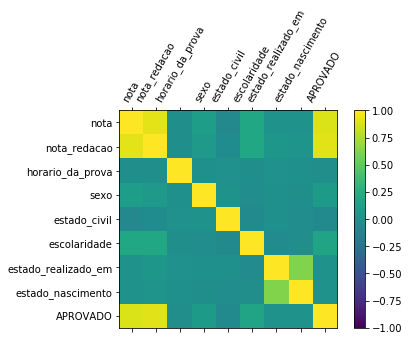

In [67]:
# Matriz de Correlação com nomes das variáveis
correlations = df.corr()

colunas = [
    'nota',
    'nota_redacao',
    'horario_da_prova',
    'sexo',
    'estado_civil',
    'escolaridade',
    'estado_realizado_em',
    'estado_nascimento',
    'APROVADO'
    ]
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin = -1, vmax = 1)
fig.colorbar(cax)
ticks = np.arange(0, 9, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(colunas, rotation=60)
ax.set_yticklabels(colunas)
plt.show()

#  
#  

<a id='model'></a>
# Modelos estatísticos

Será utilizado modelos estatísticos surpevisionados de classificação, levando em conta a nota objetiva do aluno, para posterior analise será adicionado a nota de redação.

## Naive Bayes

Algoritmo Não-Linear.  

Calcula a Probabilidade de cada classe e a probabilidade condicional de cada classe dado uma variável de entrada. As probabilidades são então estimadas para os novos dados e multiplicadas, assumindo que são independentes (suposição simples ou Naive).

In [68]:
# Eliminação Recursiva de Variáveis

# Import dos módulos

from pandas import read_csv
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Carregando os dados

colunas = [
    'horario_da_prova',
    'sexo',
    'estado_civil',
    'escolaridade',
    'estado_realizado_em',    
    'estado_nascimento',
    'APROVADO'
]
df_model = pd.DataFrame(df, columns=colunas)


array = df_model.values

# Separando o array em componentes de input e output

X = array[:,0:(len(colunas)-1)]
Y = array[:,(len(colunas)-1)]

# Criação do modelo

modelo = LogisticRegression()

# RFE

rfe = RFE(modelo, 3)
fit = rfe.fit(X, Y)

# Print dos resultados

print("Número de Atributos: %d" % fit.n_features_)
print(df_model.columns[0:(len(colunas)-1)])
print("Atributos Selecionados: %s" % fit.support_)
print("Ranking dos Atributos: %s" % fit.ranking_)

Número de Atributos: 3
Index(['horario_da_prova', 'sexo', 'estado_civil', 'escolaridade',
       'estado_realizado_em', 'estado_nascimento'],
      dtype='object')
Atributos Selecionados: [False  True  True  True False False]
Ranking dos Atributos: [2 1 1 1 3 4]


Sexo, Estado Civil e Escolaridade são as variáveis que melhor representam o modelo

In [70]:
from sklearn import model_selection
from sklearn.naive_bayes import GaussianNB

# Vamos inicialmente selecionar algumas colunas como variaveis preditoras
# APROVADO como variavel target
colunas = [
    'sexo',
    'estado_civil',
    'escolaridade',
    'APROVADO'
]
df_model = pd.DataFrame(df, columns=colunas)

array = df_model.values

# Separando o array em componentes de input e output
X = array[:,0:(len(colunas)-1)]
Y = array[:,(len(colunas)-1)]

# Definindo os valores para o número de folds
num_folds = 10
num_instances = len(X)

# Separando os dados em folds
kfold = model_selection.KFold(num_folds, True)

# Criando o modelo
modelo = GaussianNB()
resultado = model_selection.cross_val_score(modelo, X, Y, cv = kfold)

# Print do resultado
print(resultado.mean())

0.5955537504470986
